# 집계 연산
집계(aggregation)은 빅데이터 분석의 초석입니다.
집계를 수행하려면 key와 group을 지정하고, 하나 이상의 칼럼을 변환하는 방법을 지정하는 집계함수를  사용합니다.


Spark는 모든 데이터 타입을 다루는 것 외에도 다음과 같은 그룹화 데이터 타입을 생성할 수 있습니다.
* 가장 간단한 형태의 그룹화는 select 구문에서 집계를 수행해 DataFrame의 전체 데이터를 요약한다.
* `group by`는 하나 이상의 키를 지정할 수 있고, 값을 가진 컬럼을 변환하기 위해 다른 집계함수를 사용할 수 있다.
* 윈도우(window)는 하나이상의 키를 지정할 수 있고, 값을 가진 컬럼을 변환하기 위해 다른 집계함수를 이용할 수 있다. 하지만, 함수의 입력으로 사용할 로는 현재 로우랑 어느정도의 연관성이 있어야합니다.
* 그룹화셋(grouping set)은 서로 다른 레벨을 집계할 때 사용한다. SQL, DataFrame의 롤업, 그리고 큐브를 사용할 수 있다.
* 롤업(roll up)은 하나 이상의 키를 지정할 수 있다. 그리고 컬럼을 변환하는데 다른 집계함수를 이용해 계층적으로 요약된 값을 구할 수 있다.
* 큐브(cube)는 하나 이상의 키를 지정할 수 있고, 값을 가진 컬럼을 변환하기 위해 다른 집계함수를 가용할 수 있다. 큐브는 모든 컬럼 조합에 대해 요약값을 가진다.

지정된 집계 함수에 따라 그룹화된 결과는 RelationalGroupedDataset을 반환한다.
> 반드시 명심할 사항은 어떤 결과를 만들어야할 지 정확히 파악을 해야한다는 것이다. 빅데이터를 사용해 연산을 수행하는 겨웅, 질문에 대한 정확한 답을 얻기 위해 연산, 네트워크, 저장소 등 상당한 비용이 들 수 밖에 없다. 그러므로 수용 가능한 정도의 정확도에 맞춰 근사치를 계산하는 것이 비용을 고려했을 때 더 효과적이다.
> 이책에서 몇 가지 근사치 계산용 함수를 소개한다. 근사치 계산용 함수를 사용해 스파크 잡의 실행 속도를 개선할 수 있다. 특히 대화형 셸을 이용해 비정형 분석을 수행하는 경우, 유용하다.

구매 이력 데이터를 이용해 파티션을 훨씬 적은 수로 분할할 수 있도록 리파티셔닝하고 빠르게 접근할 수 있도록 캐싱하겠다.
파티션 수를 줄이는 이유는 적은 양의 데이터를 가진 수많은 파일이 존재하기 때문이다.
https://www.dbta.com/Editorial/Trends-and-Applications/Spark-and-the-Fine-Art-of-Caching-119305.aspx

In [39]:
df = spark.read.format("csv").option("header","true").option("inferSchema", "true")\
.load("./data/retail-data/all/*.csv").coalesce(5)
df.cache()
df.createOrReplaceTempView("dfTable")

In [40]:
df.show(2,False)

+---------+---------+----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN               |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
+---------+---------+----------------------------------+--------+--------------+---------+----------+--------------+
only showing top 2 rows



DataFrame을 이용해 기본 집계를 수행해보자. 다음은 `count` 메소드를 활용한 간단한 예제이다.
`count` 메소드는 트랜스포메이션이 아닌 액션이므로 결과를 즉시 반환한다.
지금은 `count` 함수가 메소드 형태로 존재하고,트랜스포메이션처럼 지연 연산 방식이 아닌 즉시 연산을 수행하기 때문이다.
지연연산 방식으로 `count` 메소드를 사용하는 방법을 알아보자.

In [41]:
df.count()

541909

## Aggregation Functions
집계함수는 `org.apache.spark.sql.functions` 패키지에서 찾아볼 수 있다.


### count
`count` 함수는 두 가지 방식으로 사용할 수 있다. 하나는 `count` 함수에 특정 컬럼을 지정하는 방식이고, 하나는 `count(*)` 혹은 `count(1)` 를 사용하는 방식이다.
> null 값이 포함된 데이터의 레코드 수를 구할 때 `count(*)` 구문을 사용하면 null 값을 가진 로우를 포함해 카운드 한다. 하지만, count 함수에 특정 컬럼을 지정하면 null 은 포함되지 않는다.

In [42]:
from pyspark.sql.functions import count

df.select(count("StockCode")).show()

+----------------+
|count(StockCode)|
+----------------+
|          541909|
+----------------+



### countDistinct

전체 레코드 수가 아닌 고유의 레코드 수를 구해야한다면 countDistinct 함수를 사용해야한다. 이 함수는 개별 컬럼을 처리하는데 유리하다.

In [43]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("StockCode")).show()

+-------------------------+
|count(DISTINCT StockCode)|
+-------------------------+
|                     4070|
+-------------------------+



### approx_count_distinct
대규모 데이터셋을 다루다보면 정확한 고유 개수가 무의미해지는 경우가 있다.  어느 정도의 정확도를 가지는 근사치만으로 유의미하다면 `approx_count_distinct` 함수를 사용해 근사치를 계산할 수 있다.

In [46]:
from pyspark.sql.functions import approx_count_distinct

df.select(approx_count_distinct("StockCode",0.1)).show(2,False)
df.select(approx_count_distinct("StockCode",0.01)).show(2,False)

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|3364                            |
+--------------------------------+

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|4079                            |
+--------------------------------+



`approx_count_distinct` 함수는 **최대 추정 오차율(maximumu estimation error)** 라는 한 가지 파라미터를 더 사용한다. 예제는 큰 오류율을 설정했기 떄문에 기대치에서 크게 벗어난 결과를 얻지만, `countDistinct` 함수보다 더 빠르게 결과를 반환한다.

이 함수의 성능은 대규모 데이터셋을 사용할 때 훨씬 더 좋아진다.

### first and last
`first`와 `last` 는 DataFrame의 첫 번째 값과 마지막 값을 얻을 떄 사용한다.

In [9]:
from pyspark.sql.functions import first, last
df.select(first("StockCode"), last("StockCode")).show(1,False)

+----------------+---------------+
|first(StockCode)|last(StockCode)|
+----------------+---------------+
|85123A          |22138          |
+----------------+---------------+



### min 과 max
DataFrame에 최댓값과 최솟값을 추출하려면 `min` 과 `max`함수를 사용한다.

In [10]:
from pyspark.sql.functions import min, max
df.select(min("Quantity"), max("Quantity")).show(2,False)

+-------------+-------------+
|min(Quantity)|max(Quantity)|
+-------------+-------------+
|-80995       |80995        |
+-------------+-------------+



### sum
DataFrame 에 특정 칼럼의 모든 값을 합산하려면 sum 함수를 사용합니다.



In [11]:
from pyspark.sql.functions import sum
df.select(sum("Quantity")).show(2,False)

+-------------+
|sum(Quantity)|
+-------------+
|5176450      |
+-------------+



### sumDistinct
특정 칼럼의 모든 값을 합산하는 방법 외에도 sumDistinct 함수를 사용해 고윳값을 합산할 수 있습니다.

In [12]:
from pyspark.sql.functions import sumDistinct
df.select(sumDistinct("Quantity")).show(2,False)

+----------------------+
|sum(DISTINCT Quantity)|
+----------------------+
|29310                 |
+----------------------+



### avg
`sum` 함수 결과를 `count` 함수의 결과로 나누어 평균값을 구할 수 있지만, Spark 의 `avg` 나 `mean` 함수를 이용해 더 쉽게 구할 수 있다.
> #### pyspark.sql.functions.mean(col)
Aggregate function: returns the average of the values in a group.



> #### pyspark.sql.functions.avg(col)[source]
Aggregate function: returns the average of the values in a group.


In [13]:
from pyspark.sql.functions import sum,count, avg, expr

df.select(
    count("Quantity").alias("total_transactions"),
    sum("Quantity").alias("total_purchases"),
    avg("Quantity").alias("avg_purchases"),
    expr("mean(Quantity)").alias("mean_purchases"))\
   .selectExpr(
      "total_purchases/total_transactions",
"avg_purchases",
"mean_purchases").show()

+--------------------------------------+----------------+----------------+
|(total_purchases / total_transactions)|   avg_purchases|  mean_purchases|
+--------------------------------------+----------------+----------------+
|                      9.55224954743324|9.55224954743324|9.55224954743324|
+--------------------------------------+----------------+----------------+



### Variance and Standart Deviation
평균을 구하다보면 자연스럽게 분산과 표준편차가 궁금해진다. 분산과 표준편차는 평균 주변에 데이터가 분포된 정도를 측정하는 방법이다. 
* 분산은 평균과의 차이를 제곱한 결과의 평균이다.
* 표준편차는 분산의 제곱근이다.
스파크에서 함수를 사용해 분산과 표준편차를 계산할 수 있다. 스파크는 표본 표준 편차 뿐만 아니라, 모표준편차 방식도 지원하기 때문에 주의해야한다.
* variance  함수이나 stddev 함수를 사용한다면, 기본적으로 표본 표준 분산과 표본표준편차 공식을 이용한다.
* 모표준분산이나 모표준편차 방식을 사용하려면 다음 예제와 같이 `var_pop` 함수나  `stddev_pop` 함수를 사용한다.


분산은 평균과의 차이를 제곱한 결과의 평균이며 표준편차는 분산의 제곱근이다. SPARK 에서는 함수를 사용해 분산과 표준편차를 구할 수 있다.
`variance` 함수나 `stddev` 함수를 사용한다면 기본적으로 **표본표준분산(Sample Standard Variance )** 과 표본 표준편차 공식을 이용합니다.
**모표준분산(Popupulation Standard Variance)** 이나 모표준편차 방식을 사용하려면 다음 예제와 같이 `var_pop` 함수나 `stddev_pop` 함수를 사용합니다.
VAR_SAMP 및 VARIANCE는 동일한 함수이기 때문에 동의어나 마찬가지입니다.
> VAR_SAMP 및 VAR_POP 함수는 숫자 값(정수, 소수 또는 부동 소수점) 집합의 표본 분산과 모 분산을 반환합니다. 
VAR_SAMP 함수의 결과는 동일한 값 집합의 표본 표준 편차를 제곱한 것과 동일합니다.




In [14]:
from pyspark.sql.functions import var_pop,stddev_pop
from pyspark.sql.functions import var_samp, stddev_samp


df.select(var_pop("Quantity"), var_samp("Quantity"), stddev_pop("Quantity"), stddev_samp("Quantity")).show()

+-----------------+------------------+--------------------+---------------------+
|var_pop(Quantity)|var_samp(Quantity)|stddev_pop(Quantity)|stddev_samp(Quantity)|
+-----------------+------------------+--------------------+---------------------+
| 47559.3036466091|  47559.3914092988|  218.08095663447807|   218.08115785023426|
+-----------------+------------------+--------------------+---------------------+



### 비대칭도와 첨도
비대칭도와 첨도 모두 데이터의 변곡점(extreme point)을 측정하는 방법이다. 
* 비대칭도(skewness)는 데이터 평균의 비대칭 정도를 측정하고,
* 첨도(kurtosis)는 데이터 끝 부분을 측정합니다. 
비대칭도와 첨도는 확률변수(random variable)의 확률분포(random distribution)로 데이터를 모델링할 때, 특히 중요합니다. 


> 비대칭도: 실숫값 확률변수와 확률 분표 비대칭성을 나타내는 지표이다. 왜도라고 한다.
> 첨고: 확률 분포의 뾰족한 정도를 나타내는 척도이다.

In [15]:
from pyspark.sql.functions import skewness, kurtosis

df.select(skewness("Quantity"), kurtosis("Quantity")).show(1, False)

+--------------------+------------------+
|skewness(Quantity)  |kurtosis(Quantity)|
+--------------------+------------------+
|-0.26407557610529564|119768.05495534712|
+--------------------+------------------+



### 공분산과 상관관계
두 칼럼값 사이에 영향도를 비교하는 함수를 알아보겠습니다. `cov` 와 `corr` 함수를 이용해 공분산(Covariance)과 상관관계(Correlation)을 계산할 수 있습니다.

공분산은 데이터 입력값에 따라 다른 범위를 가집니다. 상관관계는 피어슨 상관계수(Pearson Correlation Coefficient)를 측정하며, -1과 1 사이의 값을 가진다.

`var` 함수 처럼 **표본공분산(Sample Covariance)** 방식이나 **모공분산(Population Coveriance)** 방식으로 공분산을 계산할 수 있다. 상관관계는 모집단이나 표본에 대한 개념이 없다. 
공분산과 상관관계를 수행하는 방법은 다음과 같다.



In [16]:
from pyspark.sql.functions import corr, covar_pop, covar_samp

df.select(corr("InvoiceNo", "Quantity"), covar_samp("InvoiceNo", "Quantity"), covar_pop("InvoiceNo", "Quantity")).show(2,False)

+-------------------------+-------------------------------+------------------------------+
|corr(InvoiceNo, Quantity)|covar_samp(InvoiceNo, Quantity)|covar_pop(InvoiceNo, Quantity)|
+-------------------------+-------------------------------+------------------------------+
|4.912186085642775E-4     |1052.7280543915654             |1052.7260778754612            |
+-------------------------+-------------------------------+------------------------------+



### 복합 데이터 타입의 집계
스파크는 수식을 이용한 집계뿐만 아니라 복합 데이터 타입을 사용해 집계를 사용할 수 있다. 예를들어 특정 컬럼의 값을 리스트로 수집하거나, 셋 데이터 타입으로 고윳값만 수집할 수 있다.

수집한 데이터는 처리 파이프라인에서 다양한 프로그래밍 방식으로 다루거나 사용자 정의 함수를 이용해 전체 데이터에 접근할 수 있다.



In [17]:
from  pyspark.sql.functions import collect_set, collect_list

df.agg(collect_set("Country"), collect_list("Country")).show(1)

+--------------------+---------------------+
|collect_set(Country)|collect_list(Country)|
+--------------------+---------------------+
|[Portugal, Italy,...| [United Kingdom, ...|
+--------------------+---------------------+



## 그룹화
데이터 그룹 기반의 집계를 수행하는 경우가 더 많다. 데이터 그룹 기반의 집계는 단일 컬럼의 데이터를 그룹화하고 해당 그룹의 다른 여러 컬럼을
사용해 계산하기 위해 카테고리형 데이터를 사용합니다.

데이터 그룹 기반의 집계를 설명하는데 가장 좋은 방법은 그룹화해보는 것이다. 이전에 했던 것처럼 카운트를 먼저 수행한다. 고유한 송장번호(InvoiceNo)를 기준으로 그룹을 만들고, 그룹별 물품 수를 카운트한다. 이 연산은 또 다른 DataFrame을 반환해 지연 처리 방식으로 수행한다.

 그룹화 작업은 하나 이상의 컬럼을 그룹화하고 집계 연산을 수행하는 두단계로 이뤄진다.

첫 번째 단계에서 RelationalGroupedDataset이 반환되고, 두 번째 단계에서 DataFrame이 반환된다. 그룹의 기준이 되는 컬럼을 여러 개 지정할 수 있다.

In [18]:
df.groupBy("InvoiceNo", "CustomerID").count().show()

+---------+----------+-----+
|InvoiceNo|CustomerID|count|
+---------+----------+-----+
|   536846|     14573|   76|
|   537026|     12395|   12|
|   537883|     14437|    5|
|   538068|     17978|   12|
|   538279|     14952|    7|
|   538800|     16458|   10|
|   538942|     17346|   12|
|  C539947|     13854|    1|
|   540096|     13253|   16|
|   540530|     14755|   27|
|   541225|     14099|   19|
|   541978|     13551|    4|
|   542093|     17677|   16|
|   543188|     12567|   63|
|   543590|     17377|   19|
|  C543757|     13115|    1|
|  C544318|     12989|    1|
|   544578|     12365|    1|
|   536596|      null|    6|
|   537252|      null|    1|
+---------+----------+-----+
only showing top 20 rows



### 표현식을 이용한 그룹화
카운팅은 메서드로 사용할 수 있으므로 특별하다. 하지만, 메서드 대신 `count` 함수를 사용할 것을 추천한다.또한  `count` 함수를 `select` 구문에 표현식으로 지정하는 것보다  `agg` 메서드를 사용해야한다.
* `agg` 메서드는 여러 집계 처리를 한 번에 지정할 수 있고, 집계에 표현식을 사용할 수 있다.
* 또한,  트랜스포메이션이 완료된 컬럼에 `alias` 메서드를 사용할 수 있다.

In [19]:
from pyspark.sql.functions import count

df.groupBy("InvoiceNo").agg(
count("Quantity").alias("quan"),
expr("count(Quantity)")).show()

+---------+----+---------------+
|InvoiceNo|quan|count(Quantity)|
+---------+----+---------------+
|   536596|   6|              6|
|   536938|  14|             14|
|   537252|   1|              1|
|   537691|  20|             20|
|   538041|   1|              1|
|   538184|  26|             26|
|   538517|  53|             53|
|   538879|  19|             19|
|   539275|   6|              6|
|   539630|  12|             12|
|   540499|  24|             24|
|   540540|  22|             22|
|  C540850|   1|              1|
|   540976|  48|             48|
|   541432|   4|              4|
|   541518| 101|            101|
|   541783|  35|             35|
|   542026|   9|              9|
|   542375|   6|              6|
|  C542604|   8|              8|
+---------+----+---------------+
only showing top 20 rows



### 맵을 이용한 그룹화
칼럼을 Key로 수행할 집계 함수의 문자열을 Value로 하는 Map 타입을 이용해 트랜스포메이션을 정의할 수 있다.
수행할 집계 함수를 한 줄로 작서아면 여러 칼럼명을 재사용할 수 있다.

In [20]:
df.groupBy("InvoiceNo").agg(expr("avg(Quantity)"), expr("stddev_pop(Quantity)")).show(4, False)

+---------+------------------+--------------------+
|InvoiceNo|avg(Quantity)     |stddev_pop(Quantity)|
+---------+------------------+--------------------+
|536596   |1.5               |1.1180339887498947  |
|536938   |33.142857142857146|20.698023172885524  |
|537252   |31.0              |0.0                 |
|537691   |8.15              |5.597097462078001   |
+---------+------------------+--------------------+
only showing top 4 rows



## 윈도우 함수
윈도우 함수(window function)를 집계에 사용할 수 있다. 윈도우 함수는 데이터의 특정 윈도우를 대상으로 고유의 집계 연산을 수행한다. 데이터의 윈도우는 현재 데이터에 대한 참조를 정의해 사용한다.

윈도우(window specification)는 함수에 전달된 로우를 결정한다. 표준 `group-by` 와 유사해 보일 수 있으니 차이를 알아보자. 
`group-by` 함수는 모든 로우 기반의 테이블을 의미한다. 각 로우는 하나 이상의 프레임에 할당될 수 있다.

WindowSpec. 집계 함수로 작업 할 때 order by 절을 사용할 필요가 없습니다.


가장 흔하게 사용되는 방법 중 하나는 하루를 나타내는 값에 **롤링 평균(Rolling Average)** 를 수하는 것이다. 이 작업을 수행하려면 개별 로우가 7개의 다른 프레임으로 구성돼야한다. 프레임을 정의하는 방법은 있다 알아보자.



Spark 는 3가지 종류의 윈도우 함수를 지원한다.
* Ranking Function(랭크 함수)
* Analytic Function(분석 함수)
* Aggregate Function(집계 함수)

Example1은 로우가 어떻게 여러 프레임에 할당될 수 있는지 나타낸다.
> Example 1 - Visualizing window  Functions
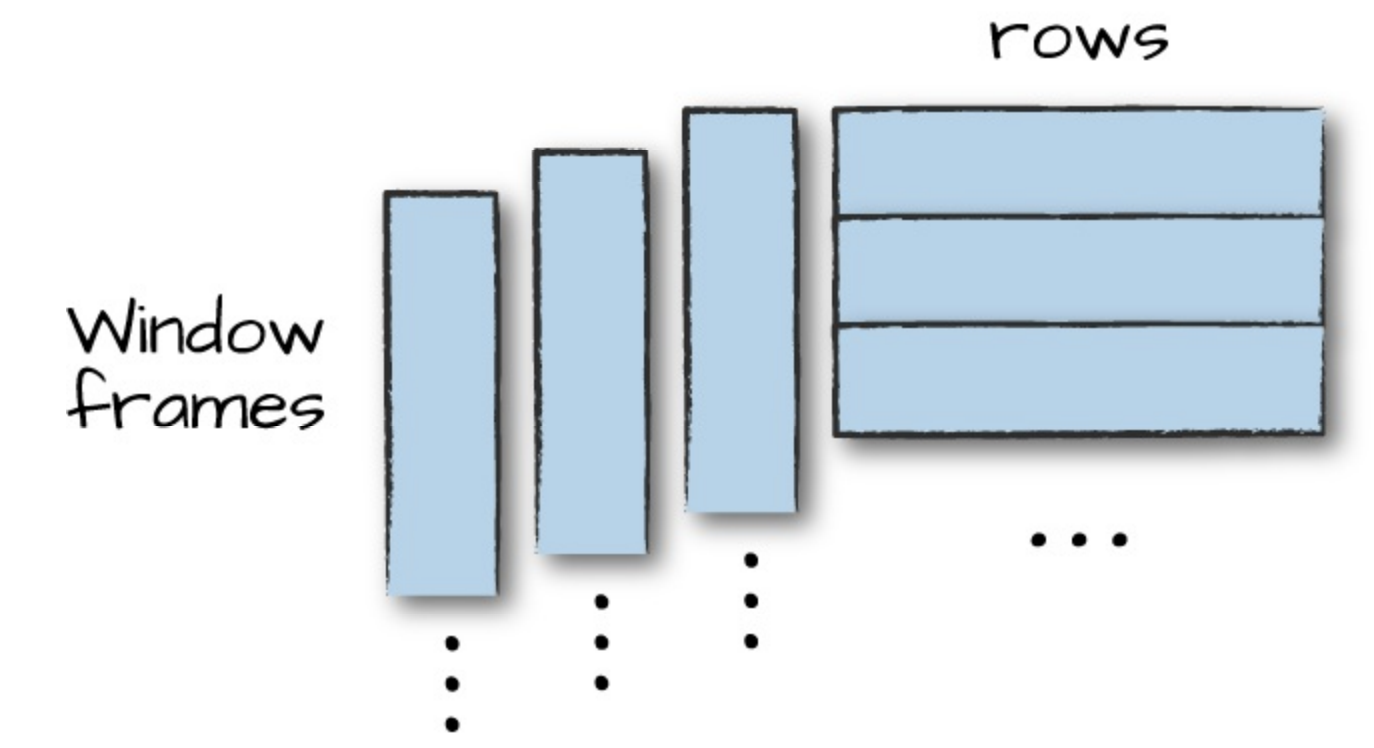

예제를 위해 주문일자(InvoiceNo) 컬럼을 변환해 date 컬럼을 만든다. 이 컬럼을 시간 정보르 ㄹ제외한 날짜 정보만 가진다.

In [21]:
from pyspark.sql.functions import col,to_date

dfWithDate = df.withColumn("date", \
                           to_date(col("InvoiceDate"), "MM/d/yyy H:mm"))
dfWithDate.createOrReplaceTempView("dfWithDate")

윈도우 함수를 정의하기 위해 첫 번째 단계로 윈도우 명세를 만든다. 여기서 사용하는 `partitionBy` 메서드는 지금까지 사용해온 파티셔닝 스키마 개념과는 관련이 없고, 그룹을 어떻게 나눌지 결정하는 것과 유사한 개념이다. `orderBy` 메서드는 파티션의 정렬 방식을 정의한다. 그리고 프레임 명세(`rowsBetween` 구문)는 입력된 로우의 참조를 기반으로 프레임에 로우가 포함될 수 있는지 결정한다.

다음예제에서는 첫 로우부터 현 로우까지 확인한다.

In [22]:
from pyspark.sql.functions import desc
from pyspark.sql.window  import Window

windowSpec = Window\
.partitionBy("CustomerID", "date")\
.orderBy(desc("Quantity"))\
.rowsBetween(Window.unboundedPreceding, Window.currentRow)

windowSpec

이제 집계 함수를 이용해 고객을 좀 더 자세히 살펴보자. 여기서 시간재별 최대 구매 개수를 구하는 예를 들어보자.
그러려면  위 예제에서 사용한 집계함수에 컬럼명이나 표현식을 전달해야한다.
그리고 이 함수를 적용할 데이터 프레임이 정의된 윈도우 명세도 함께 사용한다.

In [23]:
from pyspark.sql.functions import max

maxPurchaseQuantity = max(col("Quantity")).over(windowSpec)


앞 예제는 컬럼이나 표현식을 반환하므로 DataFrame의 select 구문에서 사용할 수 있다. 먼저 구매량 순위를 만들자.
`dense_rank` 함수를 이용해 모든 고객에 대해 최대 구매수량을 가진 날짜가 언제인지 알아보자.  동일한 값이 나오거나 중복 로우가 발생해 순위가 비어있을 수 있으므로 `rank` 함수 대신에 `dense_rank` 함수를 이용한다.

In [24]:
from pyspark.sql.functions import dense_rank, rank

purchaseDenseRank = dense_rank().over(windowSpec)
purchaseRank = rank().over(windowSpec)

이 예제 또한 `select` 구문에서 사용할 수 있는 컬럼을 반호낳나다. 이제 select 메서드를 사용해 계산된 윈도우 값을 확인해보자.

In [25]:
# COMMAND ----------

from pyspark.sql.functions import col

dfWithDate.where("CustomerID IS NOT NULL").orderBy("CustomerID")\
  .select(
    col("CustomerID"),
    col("date"),
    col("Quantity"),
    purchaseRank.alias("quantityRank"),
    purchaseDenseRank.alias("quantityDenseRank"),
    maxPurchaseQuantity.alias("maxPurchaseQuantity")).show()


Py4JJavaError: An error occurred while calling o196.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 37.0 failed 1 times, most recent failure: Lost task 2.0 in stage 37.0 (TID 511) (172.30.1.60 executor driver): org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '5/24/2011 15:56' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.util.random.SamplingUtils$.reservoirSampleAndCount(SamplingUtils.scala:41)
	at org.apache.spark.RangePartitioner$.$anonfun$sketch$1(Partitioner.scala:306)
	at org.apache.spark.RangePartitioner$.$anonfun$sketch$1$adapted(Partitioner.scala:304)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2(RDD.scala:915)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2$adapted(RDD.scala:915)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.time.format.DateTimeParseException: Text '5/24/2011 15:56' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 24 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:304)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:267)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency$lzycompute(ShuffleExchangeExec.scala:155)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency(ShuffleExchangeExec.scala:149)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.$anonfun$doExecute$1(ShuffleExchangeExec.scala:166)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:163)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:525)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:453)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:452)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:746)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.window.WindowExec.doExecute(WindowExec.scala:121)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:525)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:453)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:452)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:746)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:321)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:439)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at jdk.internal.reflect.GeneratedMethodAccessor119.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '5/24/2011 15:56' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.util.random.SamplingUtils$.reservoirSampleAndCount(SamplingUtils.scala:41)
	at org.apache.spark.RangePartitioner$.$anonfun$sketch$1(Partitioner.scala:306)
	at org.apache.spark.RangePartitioner$.$anonfun$sketch$1$adapted(Partitioner.scala:304)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2(RDD.scala:915)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2$adapted(RDD.scala:915)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.time.format.DateTimeParseException: Text '5/24/2011 15:56' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 24 more


## 그룹화셋
지금까지 컬럼 값을 이용해 여러 컬럼을 집계하는데 `group-by` 표현식을 사용했습니다.

때로는 여러 그룹에 집꼐할 수 있는 무언가가 필요할 수 있다. 그룹화 셋이 바로 그 주인공이다. 그룹화 셋은 여러 집계를 결합하는 저수준의 기능이다. 그룹화 셋을 이용하면 group-by 구문에서 원하는 형태로 집계를 생성할 수 있다.

SQL 만 가능하고, DataFrame 에서 동일한 연산을 수행하려면 `rollup` 메서드로 `cube` 메서드를 사용한다. 
https://mungingdata.com/apache-spark/aggregations/

### 롤업
지금까지 명시적 그룹화를 알아보았다. 다양한 컬럼을 그룹화키로 설정하면 그룹화 키로 설정된 조합 뿐만 아니라 데이터 셋에서 볼 수 있는 실제 조합을 모두 살펴볼 수 있다. 롤업 `group-by` 스타일의 다양한 연산을 수행할 수 있는 다차원 집계 기능이다.

다음 예제는 시간(신규 Date 컬럼)과 공간(Country 컬럼)을 축으로 하는 롤업을 생성한다.
롤업의 결과로 생성된 DataFrame은 모든 날짜의 총합, 날짜별 총합, 날짜별 국가별 총합을 포함한다.

In [27]:
dfNoNull = dfWithDate.drop()
dfNoNull.createOrReplaceTempView("dfNoNull")

rolledUpDF = dfNoNull.rollup("Date","Country").agg(sum("Quantity"))\
 .selectExpr("Date", "Country", "`sum(Quantity)` as total_quantity")\
.orderBy("Date")

rolledUpDF.show()

Py4JJavaError: An error occurred while calling o219.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 38.0 failed 1 times, most recent failure: Lost task 1.0 in stage 38.0 (TID 515) (172.30.1.60 executor driver): org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '2/24/2011 16:30' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.time.format.DateTimeParseException: Text '2/24/2011 16:30' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2291)
	at org.apache.spark.rdd.RDD.$anonfun$reduce$1(RDD.scala:1120)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1102)
	at org.apache.spark.rdd.RDD.$anonfun$takeOrdered$1(RDD.scala:1524)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1512)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:187)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at jdk.internal.reflect.GeneratedMethodAccessor119.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '2/24/2011 16:30' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.time.format.DateTimeParseException: Text '2/24/2011 16:30' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 19 more


null 값을 가진 row 에서 전체 날짜의 합계를 확인할 수 있다.
롤업된 두 개의 컬럼 값이 모두 null인 row 는 두 컬럼에 속한 레코드의 전체 합계를 나타낸다.

### 큐브
큐브(cube)는 롤업을 고차원적으로 사용할 수 있게 해준다. 큐브는 요소들을 계층적으로 다루는대신 모든 차원에 대해 동일한 작업을 수행한다. 즉, 
전체 기간에 대해 날짜와 국가별 결과를 얻을 수 있다. 기존 기능 만으로 다음과 같은 정보를 가진 테이블을 만들어보자.

* 전체 날짜와 모든 국가에 대한 합셰
* 모든 국가의 날짜별 합계
* 날짜별 국가별 합계
* 전체 날짜의 국가별 합계

메서드 호출방식은 롤업과 매우 유사하고 rollup 메서드 대신 cube 메서드를 호출한다.
큐브를 사용해 테이블에있는 모든 정보를 빠르고 쉽게 조회할 수 있는 요약 정보 테이블을 만들 수있다.

In [29]:
from pyspark.sql.functions import sum

dfNoNull.cube("Date","Country").agg(sum(col("Quantity")))\
.select("Date","Country","sum(Quantity)").orderBy("Date").show()

Py4JJavaError: An error occurred while calling o243.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 40.0 failed 1 times, most recent failure: Lost task 1.0 in stage 40.0 (TID 520) (172.30.1.60 executor driver): org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '2/24/2011 16:30' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.time.format.DateTimeParseException: Text '2/24/2011 16:30' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2291)
	at org.apache.spark.rdd.RDD.$anonfun$reduce$1(RDD.scala:1120)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1102)
	at org.apache.spark.rdd.RDD.$anonfun$takeOrdered$1(RDD.scala:1524)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1512)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:187)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at jdk.internal.reflect.GeneratedMethodAccessor119.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '2/24/2011 16:30' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.time.format.DateTimeParseException: Text '2/24/2011 16:30' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 19 more


### 그룹화 메타데이터
큐브와 롤업을 사용하다 보면 집계 수준에 따라 쉽게 필터링하기 위해 집계수준을 조회하는 경우가 발생한다. 
이때, `grouping_id` 를 이용한다. `grouping_id` 는 결과 데이터셋의 집계 수준을 명시하는 컬럼을 제공한다.
예제의 쿼리는 다음과 같은 4 개의 개별화 그룹화 ID 값을 반환한다.

| 그룹화 ID  | 설명 |
| ----   | ----|
|  3     |  가장 높은 계층의 집계 결과에서 나타난다. customerID나 stockCode에 관계없이 총 수량을 제공한다.|
|2   | 개별 재고 코드의 모든 집계결과에서 나타난다. customerID에 관계없이 재고 코드별 총 수량을 제공한다.|
|1| 구매한 물품에 관계없이 customerID 를 기반으로 총 수량을 제공한다. |
|0| customerID 와 stockCode 별 조합에 따라 총 수량을 제공한다.|


> 스칼라 only
> ```
> // 스칼라 버전
> import org.apache.spark.sql.functions.{grouping_id, sum, expr}
> dfNoNull.cube("customerId", "stockCode").agg(grouping_id(), sum("Quantity"))
> .orderBy(col("grouping_id()").desc)
> .show()
> ```

### 피봇
피봇을 사용해 로우를 컬럼으로 변환할 수 있다. 현재 데이터셋에는 Country 컬럼이 있다. 피벗을 활용해 국가별 집계함수를 적용할 수 있고 쿼리를 사용해 쉽게 결과를 확인할 수 있다.

In [95]:
dfWithDate.count()

from pyspark.sql.functions import col
simple= dfWithDate.sample(False, 0.0001)
simple.show(2,False)
simple.count()

+---------+---------+-------------------------------+--------+---------------+---------+----------+--------------+----------+
|InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate    |UnitPrice|CustomerID|Country       |date      |
+---------+---------+-------------------------------+--------+---------------+---------+----------+--------------+----------+
|536864   |22456    |NATURAL SLATE CHALKBOARD LARGE |2       |12/3/2010 11:27|10.17    |null      |United Kingdom|2010-12-03|
|537351   |84596G   |SMALL CHOCOLATES PINK BOWL     |1       |12/6/2010 12:23|1.25     |16898     |United Kingdom|2010-12-06|
+---------+---------+-------------------------------+--------+---------------+---------+----------+--------------+----------+
only showing top 2 rows



64

In [96]:
simple.groupBy("date").pivot("Country").agg(sum("customerID")).show()

Py4JJavaError: An error occurred while calling o568.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 299.0 failed 1 times, most recent failure: Lost task 1.0 in stage 299.0 (TID 4694) (172.30.1.60 executor driver): org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '2/25/2011 13:56' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.time.format.DateTimeParseException: Text '2/25/2011 13:56' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at jdk.internal.reflect.GeneratedMethodAccessor119.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '2/25/2011 13:56' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.time.format.DateTimeParseException: Text '2/25/2011 13:56' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 19 more


In [30]:
pivoted = dfWithDate.groupBy("date").pivot("Country").sum()

In [34]:
pivoted

DataFrame[date: date, Australia_sum(Quantity): bigint, Australia_sum(UnitPrice): double, Australia_sum(CustomerID): bigint, Austria_sum(Quantity): bigint, Austria_sum(UnitPrice): double, Austria_sum(CustomerID): bigint, Bahrain_sum(Quantity): bigint, Bahrain_sum(UnitPrice): double, Bahrain_sum(CustomerID): bigint, Belgium_sum(Quantity): bigint, Belgium_sum(UnitPrice): double, Belgium_sum(CustomerID): bigint, Brazil_sum(Quantity): bigint, Brazil_sum(UnitPrice): double, Brazil_sum(CustomerID): bigint, Canada_sum(Quantity): bigint, Canada_sum(UnitPrice): double, Canada_sum(CustomerID): bigint, Channel Islands_sum(Quantity): bigint, Channel Islands_sum(UnitPrice): double, Channel Islands_sum(CustomerID): bigint, Cyprus_sum(Quantity): bigint, Cyprus_sum(UnitPrice): double, Cyprus_sum(CustomerID): bigint, Czech Republic_sum(Quantity): bigint, Czech Republic_sum(UnitPrice): double, Czech Republic_sum(CustomerID): bigint, Denmark_sum(Quantity): bigint, Denmark_sum(UnitPrice): double, Denmark_s

DataFrame은 국가명, 수치형 변수, 그리고 날짜를 나타내는 컬럼을 조합한 컬럼을 가진다.
예를 들어 USA 와 관련된 컬럼을 살펴보면 `USA_sum(Quantity)`, `USA_sum(UnitPrice)` 그리고 `USA_sum(CustomerID)` 가 있다. 또한, 집계를 수행했기 때문에 수치형 컬럼으로 나타난다.

In [36]:
pivoted.printSchema()

root
 |-- date: date (nullable = true)
 |-- Australia_sum(Quantity): long (nullable = true)
 |-- Australia_sum(UnitPrice): double (nullable = true)
 |-- Australia_sum(CustomerID): long (nullable = true)
 |-- Austria_sum(Quantity): long (nullable = true)
 |-- Austria_sum(UnitPrice): double (nullable = true)
 |-- Austria_sum(CustomerID): long (nullable = true)
 |-- Bahrain_sum(Quantity): long (nullable = true)
 |-- Bahrain_sum(UnitPrice): double (nullable = true)
 |-- Bahrain_sum(CustomerID): long (nullable = true)
 |-- Belgium_sum(Quantity): long (nullable = true)
 |-- Belgium_sum(UnitPrice): double (nullable = true)
 |-- Belgium_sum(CustomerID): long (nullable = true)
 |-- Brazil_sum(Quantity): long (nullable = true)
 |-- Brazil_sum(UnitPrice): double (nullable = true)
 |-- Brazil_sum(CustomerID): long (nullable = true)
 |-- Canada_sum(Quantity): long (nullable = true)
 |-- Canada_sum(UnitPrice): double (nullable = true)
 |-- Canada_sum(CustomerID): long (nullable = true)
 |-- Channel 

In [35]:
pivoted.where("date > '2011-12-05'").select("date","`USA_sum(Quantity)`").show()

Py4JJavaError: An error occurred while calling o273.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 51.0 failed 1 times, most recent failure: Lost task 3.0 in stage 51.0 (TID 743) (172.30.1.60 executor driver): org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '8/18/2011 8:51' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.time.format.DateTimeParseException: Text '8/18/2011 8:51' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at jdk.internal.reflect.GeneratedMethodAccessor119.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '8/18/2011 8:51' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.time.format.DateTimeParseException: Text '8/18/2011 8:51' could not be parsed at index 0
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2046)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1874)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 19 more


이제 컬럼의 모든 값을 단일 그룹화해서 계산할 수 있다. 하지만, 데이터를 탐색하는 방식에 따라 피벗을 수행한 결과값이 감소할 수 있다. 특정 컬럼의 카디널리티가 낮다면 스키마의 쿼리 대상을 확인할 수 있도록 피벗을 사용해 다수의 컬럼으로 변환하는 것이 좋다. (????)

## 사용자 정의 집계함수
사용자 정의 집계함수 (user-defined aggregation function , UDAF)는 직접 제작한 함수나 비즈니스 규칙에 기반을 둔 자체 집계 함수로 정의하는 방법이다. UDAF를 이용해 입력 데이터 그룹에 직접 개발한 연산을 수행할 수 있다. 스파크는 입력 데이터의 모든 그룹의 중간 결과를 단일 AggregationBuffer 에 저장해 관리한다.

UDAF를 생성하려면 기본 클래스인 UserDefinedAggregationFunction을 상속받는다. 그리고 다음과 같은 메서드를 정의한다.
* inputSchema: UDAF  입력 파라미터의 스키마를 StructType으로 정의
* bufferSchema: UDAF 중간 결과의 스키마를 StructType으로 정의
* dataType : 반환될 타입의 DataType을 정의
* deterministic: UDAF가 동일한 입력값에 대해 항상 동일한 결과를 반환하는지 불리언값으로 정의
* initialize: 집계용 버퍼의 값을 초기화하는 로직을 정의
* update: 입력받은 로우를 기반으로 내부 버퍼를 업데이트하는 로직을 정의
* merge: 두 개용 집계용 버퍼를 병합하는 로직을 정의
* evaluate: 집계의 최종 결과를 생성하는 로직을 저으이

다음 예제는 입력된 모든 로우의 컬럼이 true 인지 아닌지 판단하는 BoolAnd 클래스를 구현한다. 만약에 하나의 컬럼이라도 true 가 아니면 false를 반환한다.

> 스칼라, 자바 only
```

// 스칼라 버전
import org.apache.spark.sql.expressions.MutableAggregationBuffer
import org.apache.spark.sql.expressions.UserDefinedAggregateFunction
import org.apache.spark.sql.Row
import org.apache.spark.sql.types._
class BoolAnd extends UserDefinedAggregateFunction {
  def inputSchema: org.apache.spark.sql.types.StructType =
    StructType(StructField("value", BooleanType) :: Nil)
  def bufferSchema: StructType = StructType(
    StructField("result", BooleanType) :: Nil
  )
  def dataType: DataType = BooleanType
  def deterministic: Boolean = true
  def initialize(buffer: MutableAggregationBuffer): Unit = {
    buffer(0) = true
  }
  def update(buffer: MutableAggregationBuffer, input: Row): Unit = {
    buffer(0) = buffer.getAs[Boolean](0) && input.getAs[Boolean](0)
  }
  def merge(buffer1: MutableAggregationBuffer, buffer2: Row): Unit = {
    buffer1(0) = buffer1.getAs[Boolean](0) && buffer2.getAs[Boolean](0)
  }
  def evaluate(buffer: Row): Any = {
    buffer(0)
  }
}


// 클래스를 초기화하고, 함수로 등록한다.


val ba = new BoolAnd
spark.udf.register("booland", ba)
import org.apache.spark.sql.functions._
spark.range(1)
  .selectExpr("explode(array(TRUE, TRUE, TRUE)) as t")
  .selectExpr("explode(array(TRUE, FALSE, TRUE)) as f", "t")
  .select(ba(col("t")), expr("booland(f)"))
  .show()


```

## 정리
이 장에서는 스파크에서 사용가능한 여러 유형의 집계 연산에 대해 알아보았다.
그룹화, 윈도우함수, 롤업, 큐브도 알아보았다.

## 별첨
### window different Example
https://sparkbyexamples.com/pyspark/pyspark-window-functions/

In [47]:
simpleData = (("James", "Sales", 3000), \
    ("Michael", "Sales", 4600),  \
    ("Robert", "Sales", 4100),   \
    ("Maria", "Finance", 3000),  \
    ("James", "Sales", 3000),    \
    ("Scott", "Finance", 3300),  \
    ("Jen", "Finance", 3900),    \
    ("Jeff", "Marketing", 3000), \
    ("Kumar", "Marketing", 2000),\
    ("Saif", "Sales", 4100) \
  )
 
columns= ["employee_name", "department", "salary"]
df = spark.createDataFrame(data = simpleData, schema = columns)
df.printSchema()
df.show(truncate=False)

root
 |-- employee_name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: long (nullable = true)

+-------------+----------+------+
|employee_name|department|salary|
+-------------+----------+------+
|James        |Sales     |3000  |
|Michael      |Sales     |4600  |
|Robert       |Sales     |4100  |
|Maria        |Finance   |3000  |
|James        |Sales     |3000  |
|Scott        |Finance   |3300  |
|Jen          |Finance   |3900  |
|Jeff         |Marketing |3000  |
|Kumar        |Marketing |2000  |
|Saif         |Sales     |4100  |
+-------------+----------+------+



In [48]:
# row_number() window 함수는 1부터 시작하여 각 창 파티션의 결과에 순차적 인 행 번호를 제공하는 데 사용됩니다.
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
windowSpec  = Window.partitionBy("department").orderBy("salary")

df.withColumn("row_number",row_number().over(windowSpec)) \
    .show(truncate=False)

+-------------+----------+------+----------+
|employee_name|department|salary|row_number|
+-------------+----------+------+----------+
|James        |Sales     |3000  |1         |
|James        |Sales     |3000  |2         |
|Robert       |Sales     |4100  |3         |
|Saif         |Sales     |4100  |4         |
|Michael      |Sales     |4600  |5         |
|Maria        |Finance   |3000  |1         |
|Scott        |Finance   |3300  |2         |
|Jen          |Finance   |3900  |3         |
|Kumar        |Marketing |2000  |1         |
|Jeff         |Marketing |3000  |2         |
+-------------+----------+------+----------+



In [49]:
# rank()창 함수는 창 파티션 내의 결과에 순위를 제공하는 데 사용됩니다. 이 기능은 동점이있을 때 순위에 차이를 남깁니다.

from pyspark.sql.functions import rank
df.withColumn("rank",rank().over(windowSpec)) \
    .show()

+-------------+----------+------+----+
|employee_name|department|salary|rank|
+-------------+----------+------+----+
|        James|     Sales|  3000|   1|
|        James|     Sales|  3000|   1|
|       Robert|     Sales|  4100|   3|
|         Saif|     Sales|  4100|   3|
|      Michael|     Sales|  4600|   5|
|        Maria|   Finance|  3000|   1|
|        Scott|   Finance|  3300|   2|
|          Jen|   Finance|  3900|   3|
|        Kumar| Marketing|  2000|   1|
|         Jeff| Marketing|  3000|   2|
+-------------+----------+------+----+



In [50]:
# dense_rank()창 함수는 간격없이 창 파티션 내에서 행 순위로 결과를 가져 오는 데 사용됩니다. 
# 이것은 rank()순위 함수가 동점 일 때 순위에 차이를 남기는 함수 차이 와 유사합니다 .이것은 DENSE_RANKSQL 의 함수 와 동일합니다 .
from pyspark.sql.functions import dense_rank
df.withColumn("dense_rank",dense_rank().over(windowSpec)) \
    .show()

+-------------+----------+------+----------+
|employee_name|department|salary|dense_rank|
+-------------+----------+------+----------+
|        James|     Sales|  3000|         1|
|        James|     Sales|  3000|         1|
|       Robert|     Sales|  4100|         2|
|         Saif|     Sales|  4100|         2|
|      Michael|     Sales|  4600|         3|
|        Maria|   Finance|  3000|         1|
|        Scott|   Finance|  3300|         2|
|          Jen|   Finance|  3900|         3|
|        Kumar| Marketing|  2000|         1|
|         Jeff| Marketing|  3000|         2|
+-------------+----------+------+----------+



In [51]:
# ntile 창 기능
#ntile()윈도우 함수는 윈도우 파티션 내 결과 행의 상대적 순위를 반환합니다. 
# 아래 예에서는 ntile에 대한 인수로 2를 사용 했으므로 2 개의 값 (1과 2) 사이의 순위를 반환합니다.
# 이것은 NTILESQL 의 함수 와 동일합니다 .
from pyspark.sql.functions import ntile
df.withColumn("ntile",ntile(2).over(windowSpec)) \
    .show()

+-------------+----------+------+-----+
|employee_name|department|salary|ntile|
+-------------+----------+------+-----+
|        James|     Sales|  3000|    1|
|        James|     Sales|  3000|    1|
|       Robert|     Sales|  4100|    1|
|         Saif|     Sales|  4100|    2|
|      Michael|     Sales|  4600|    2|
|        Maria|   Finance|  3000|    1|
|        Scott|   Finance|  3300|    1|
|          Jen|   Finance|  3900|    2|
|        Kumar| Marketing|  2000|    1|
|         Jeff| Marketing|  3000|    2|
+-------------+----------+------+-----+



더 많은 것이 궁금하다면? https://sparkbyexamples.com/pyspark/pyspark-window-functions/

### rollup vs cube

https://mungingdata.com/apache-spark/aggregations/


cube기능은 "열 목록을 소요하고 그룹화 열 모든 가능한 조합에 집계 식을 적용합니다."

In [110]:
exDF = sc.parallelize(
    [
    ("bar", 2),
  ("bar", 2),
  ("foo", 1),
  ("foo", 2)

    ]
)
exDF= sqlContext.createDataFrame(exDF, ["word", "num"])

exDF.show()

+----+---+
|word|num|
+----+---+
| bar|  2|
| bar|  2|
| foo|  1|
| foo|  2|
+----+---+



In [114]:
exDF.cube("word", "num")\
  .count()\
  .sort("word", "num")\
  .show()

+----+----+-----+
|word| num|count|
+----+----+-----+
|null|null|    4|
|null|   1|    1|
|null|   2|    3|
| bar|null|    2|
| bar|   2|    2|
| foo|null|    2|
| foo|   1|    1|
| foo|   2|    1|
+----+----+-----+



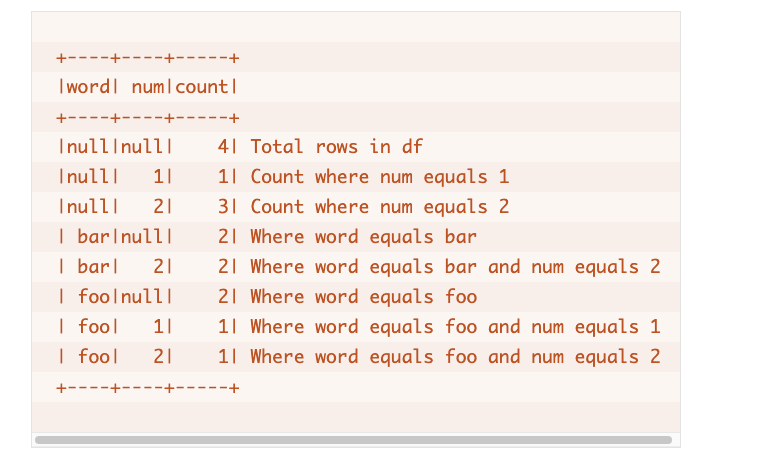



#### rollup()
rollup은 "왼쪽에서 오른쪽으로 계층 적 부분합을 계산" 의 하위 집합입니다 .

In [115]:
exDF.rollup("word", "num")\
  .count()\
  .sort("word", "num")\
  .show()

+----+----+-----+
|word| num|count|
+----+----+-----+
|null|null|    4|
| bar|null|    2|
| bar|   2|    2|
| foo|null|    2|
| foo|   1|    1|
| foo|   2|    1|
+----+----+-----+



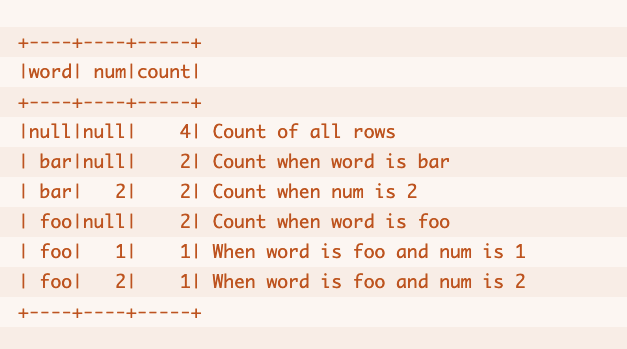

rollup()에서 반환 한 행의 하위 집합을 반환합니다 cube(). rollup6 개 행을 cube반환하고 8 개 행을 반환합니다. 

### pivot different Example

In [116]:
rdd = sc.parallelize(
    [
        (0, "A", 223,"201603", "PORT"), 
        (0, "A", 22,"201602", "PORT"), 
        (0, "A", 422,"201601", "DOCK"), 
        (1,"B", 3213,"201602", "DOCK"), 
        (1,"B", 3213,"201601", "PORT"), 
        (2,"C", 2321,"201601", "DOCK")
    ]
)
df_data = sqlContext.createDataFrame(rdd, ["id","type", "cost", "date", "ship"])

df_data.show()



df_data.groupby(df_data.id, df_data.type).pivot("date").avg("cost").show()


+---+----+----+------+----+
| id|type|cost|  date|ship|
+---+----+----+------+----+
|  0|   A| 223|201603|PORT|
|  0|   A|  22|201602|PORT|
|  0|   A| 422|201601|DOCK|
|  1|   B|3213|201602|DOCK|
|  1|   B|3213|201601|PORT|
|  2|   C|2321|201601|DOCK|
+---+----+----+------+----+

+---+----+------+------+------+
| id|type|201601|201602|201603|
+---+----+------+------+------+
|  1|   B|3213.0|3213.0|  null|
|  2|   C|2321.0|  null|  null|
|  0|   A| 422.0|  22.0| 223.0|
+---+----+------+------+------+



## 스파크 성능 최적화
https://docs.microsoft.com/ko-kr/azure/synapse-analytics/spark/apache-spark-performance